# Running Starlight and IFSCube


This notebook was created as a **step‑by‑step example** of how to run a full workflow using 
[STARLIGHT](http://www.starlight.ufsc.br/) and [IFSCube](https://ifscube.readthedocs.io/).  
The goal is to demonstrate, in a reproducible way, how to load input data, perform spectral fitting, 
and visualize the results.

The workflow covered here includes:
1. Preparing the input spectra.
2. Running STARLIGHT for stellar population synthesis and spectral fitting.
3. Processing the results with IFSCube.
4. Visualizing the results.

This notebook is intended both as a **hands‑on tutorial** and as a **quick reference** for future projects.


In [1]:
import os
import subprocess
import numpy as np
import pandas as pd
from pathlib import Path
from spectools import specutils,spectrum_io
import matplotlib.pyplot as plt


# Define your own figure configuration here
font = 12
plt.rcParams.update({
    'font.family': 'DejaVu Sans',  # ou Helvetica se estiver instalada
    'text.usetex': True,
    'font.size': font,
    'axes.titlesize': font,
    'axes.labelsize': font,
    'xtick.labelsize': font,
    'ytick.labelsize': font,
    'legend.fontsize': font,
    'figure.titlesize': font,
    'font.sans-serif': ['Helvetica']
})

Defining all the workflow directories:

In [2]:
base_dir = Path.cwd().parent   # pega o diretório onde o notebook está rodando
data_dir = base_dir / "data/A194/"

library_dir = base_dir / "data/STARLIGHTv04/CB19CSFBasesDir/"
mask_dir = base_dir / "data/STARLIGHTv04/"
starlight_dir = base_dir / "data/STARLIGHTv04/"

Generating a list of all spectra in '.txt' format in **data_dir** that will be processed with Starlight. 

In [3]:
galaxies  = [f for f in os.listdir(data_dir) if '.txt' in f]

## Creating the input file for Starlight fitting

Starlight only runs inside the STARLIGHTv04 directory, where the executable is located. 

That's why the **data_directory** needs to be defined in that way. 
Inside the next step, where you actually run Starlight, the running occours inside the **starlight_dir** defined above. 


In [4]:
conf_file = specutils.create_starlight_input_file(
    data_directory = './../A194/',
    list_galaxies = galaxies,
    n_files = 3, 
    library = 'CB19_16x5')

conf_path = mask_dir / "config.in"

with open(conf_path, "w") as f:
    f.write(conf_file)

## Running Starlight...

In [5]:
specutils.run_starlight(starlight_dir)


**> Welcome to STARLIGHT (v04) & good luck with this run!

**> Read config file: StCv04.C11.config                                                                                   
**> Read data file: spec-1079-52621-0424.txt      
    from dir = ./CB19CSFB
    Data goes from:   3734.0  -->   9049.0 Angs with N =  5316 pixels
**> ATT: Defined error & flag spectra the old way! S/N =   11.145
  [ReadSpecWithHeader] BUG! N > Nl_max!!  14000
????????????????????????????????????????????????????????????????????????????????
OOPS! You have specified i_FastBC03_FLAG = 1 (in arq_config) but the file: 
./CB19CSFBasesDir/cb19_xmilesi_z004_chab_CSF01.16.man.spec                                          
does NOT match the lambdas of BC03/STELIB!! Reverting to i_FastBC03_FLAG = 0!
????????????????????????????????????????????????????????????????????????????????
  [ReadSpecWithHeader] BUG! N > Nl_max!!  14000
  [ReadSpecWithHeader] BUG! N > Nl_max!!  14000
  [ReadSpecWithHeader] BUG! N > Nl_max!!  1

Once Starlight has run, we need to create the ".fits" file for IFSCube fitting and generate output spectra images to inspect the quality of the fit.

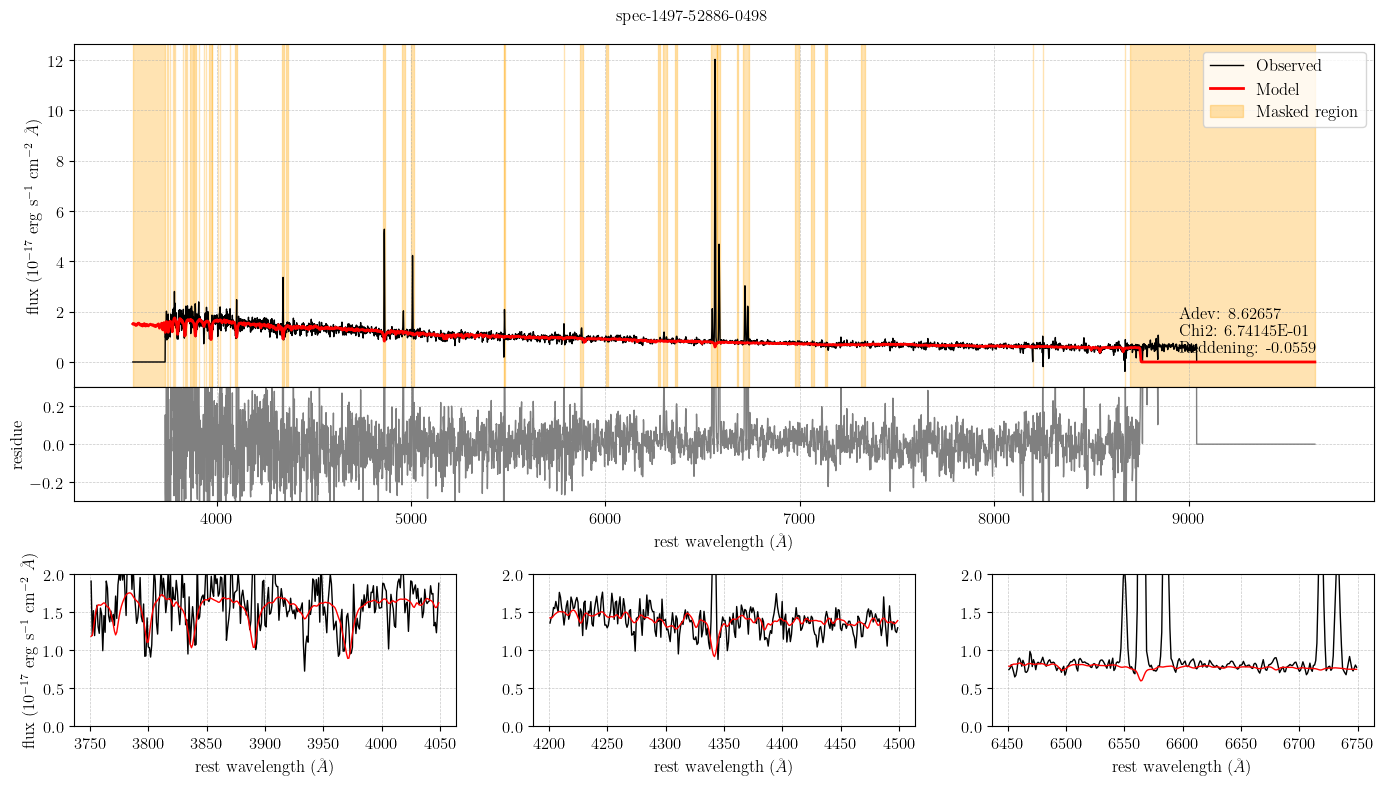

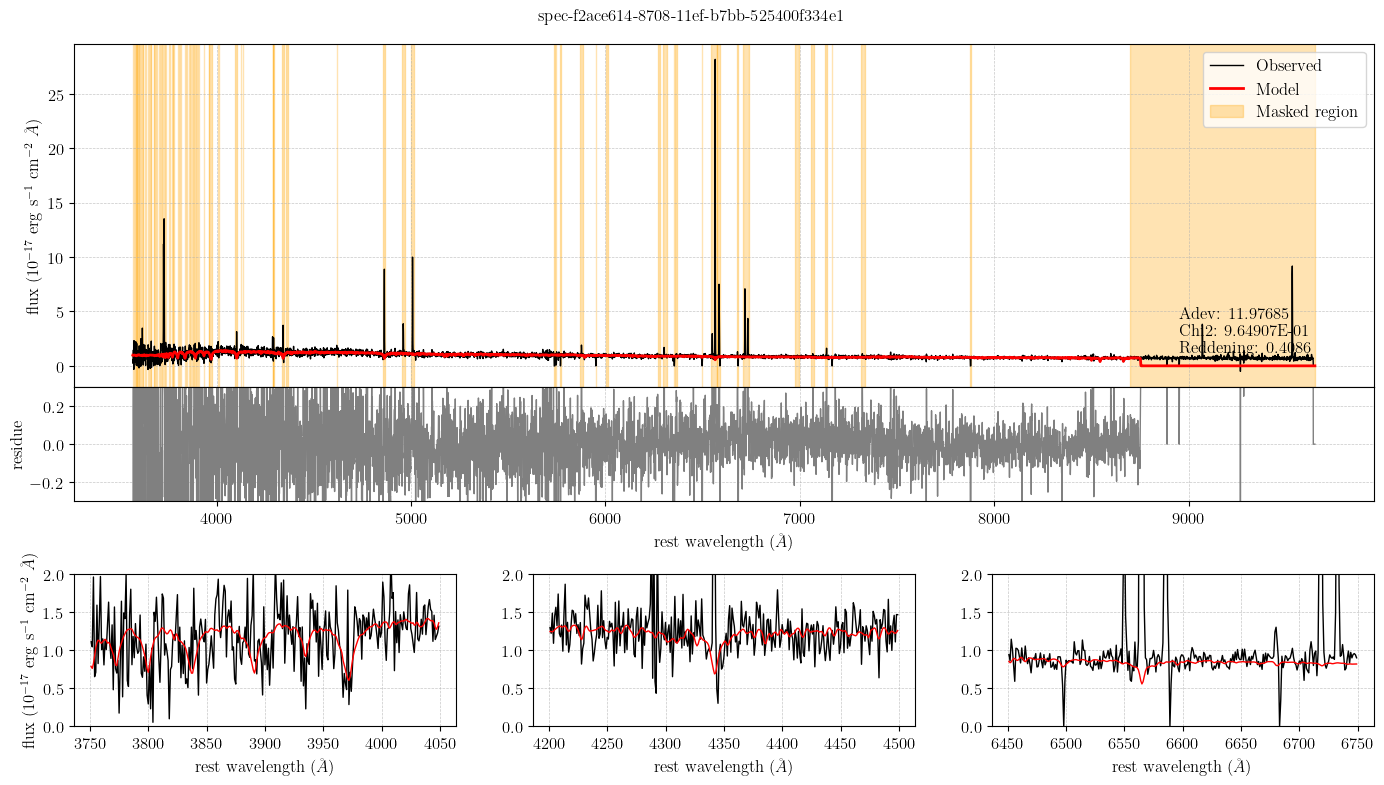

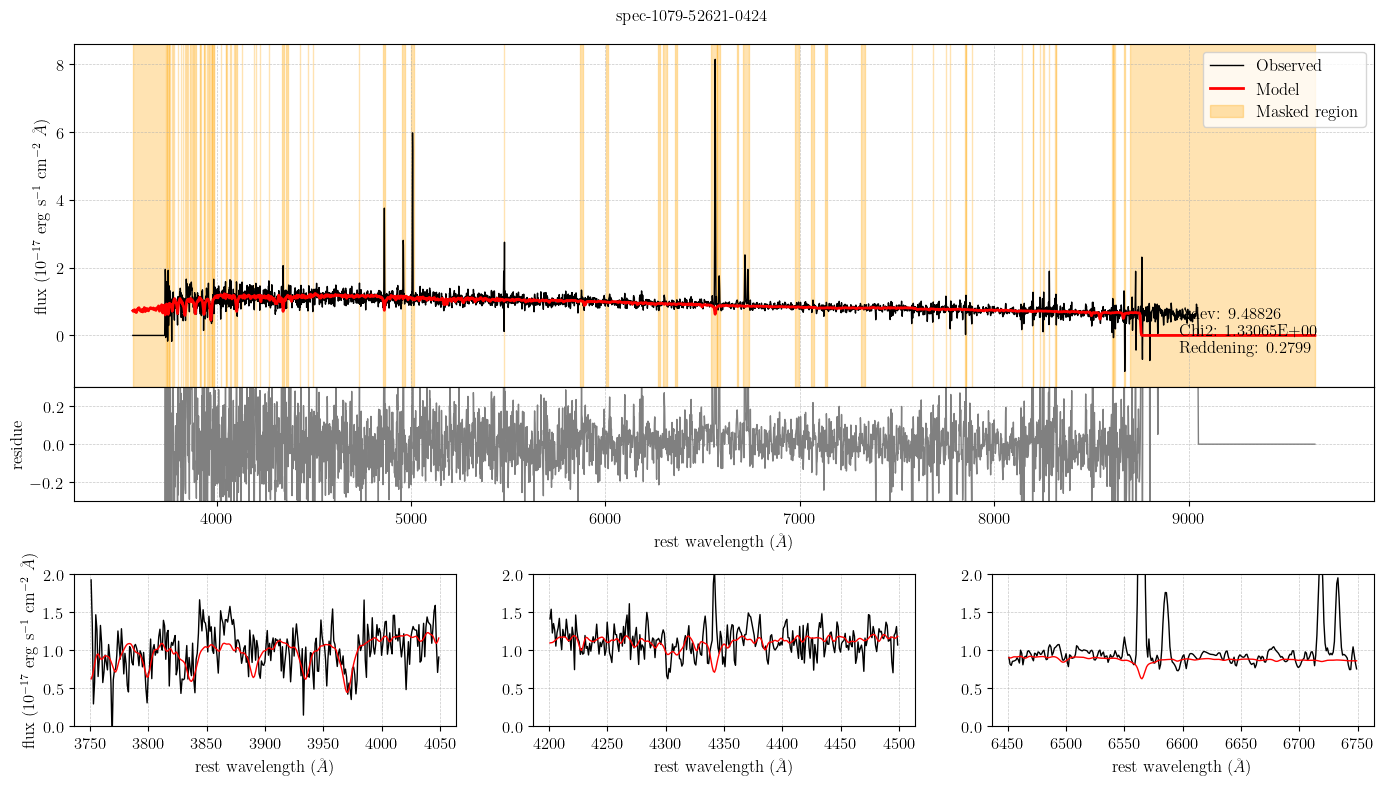

In [6]:
# After running Starlight, read the output files and saving into a list
files = [f for f in os.listdir(data_dir) if os.path.isfile(os.path.join(data_dir, f)) and  '.' not in f]
starlight_output = specutils.read_starlight_output(files, filepath=str(data_dir) + '/')

for galaxy, data in starlight_output.items():
    fig = specutils.plot_starlight_spectrum(data)
    fig.suptitle(f'{galaxy}')
    fig.tight_layout()
    fig.savefig(data_dir / f"{galaxy}_starlight.png")
    plt.show(fig)
    plt.close(fig)

    new_fits = specutils.create_new_fits_from_starlight(data)
    new_fits.writeto(data_dir / f'{galaxy}_starlight.fits', overwrite=True)


## Defining IFSCube inputs

If you want to add more emission lines in the fit, you need to add them at the "lines_config" dictionary.

In [10]:
ifscube_config_file = base_dir / 'data/ifscube_config.cfg'
stdout_ifscube = {} # to save the output log of ifscube runs
velocity = '0, +- 300'
velocity_broad = '0, +- 300'
sigma = '100, 40:400'
sigma_broad = '120, 50:200'
lines_config = {
    "OII_3726": spectrum_io.make_line(3726.032, velocity, sigma),
    "OII_3729": spectrum_io.make_line(3728.815, velocity, sigma),
    "OIII_4363": spectrum_io.make_line(4363.210, velocity, sigma),
    "Hb_4861": spectrum_io.make_line(4861.325, velocity, sigma),
    "OIII_5007": spectrum_io.make_line(5006.84, velocity, sigma, k_group=0),
    "OIII_4959": spectrum_io.make_line(4958.91, velocity, sigma,
                           amplitude="peak, 0:, OIII_5007.amplitude / 2.98", k_group=0),
    "OI_6300": spectrum_io.make_line(6300.304, velocity, sigma),
    "Ha_6563": spectrum_io.make_line(6562.80, velocity, sigma),
    "NII_6583": spectrum_io.make_line(6583.46, velocity, sigma, k_group=12),
    "NII_6548": spectrum_io.make_line(6548.04,
                          amplitude="peak, 0:, NII_6583.amplitude / 3.06", k_group=12),
    "SII_6716": spectrum_io.make_line(6716.44, velocity, sigma, k_group=13),
    "SII_6731": spectrum_io.make_line(6730.82, amplitude="peak, 0:", k_group=13),
}

## Running IFSCube

Before running IFSCube, we check if the galaxy has emission lines detected.

-> How we do that?

We define as detected the emission line that has the amplitude greater than 3 times the standard desviation of the continuum next to the line.

In [11]:
ifscube_output_files = [f for f in os.listdir(data_dir) if f.endswith('_starlight.fits')]

for file in ifscube_output_files:
    galaxy = os.path.splitext(file)[0]
    print(f' -> Checking if galaxy {galaxy} has detected emission lines... \n')
    do_fit = spectrum_io.select_do_fit(data_dir/file, value=3)
    if do_fit == True:
        out_image = data_dir / f'{galaxy}_g.fits'
        config = spectrum_io.generate_ifscube_configuration_file(continuum_degree=1, lines=lines_config, out_image=out_image)
        # print(config)
        
        with open(ifscube_config_file, "w") as f:
            f.write(config)

        output = subprocess.run(["specfit", "-oc", ifscube_config_file, data_dir/file], check=True, text=True)
        stdout_ifscube[galaxy] = output.stdout
    else: 
        print(f'Skipping galaxy {galaxy}. No emission lines detected.')

    # break


 -> Checking if galaxy spec-1497-52886-0498_starlight has detected emission lines... 



/home/kelly/Dropbox/bolsa-FAPESP/github/spectools/.venv/lib/python3.12/site-packages/ifscube/onedspec.py:109: RuntimeWarning: Wavelength read in meters. Changing it to Angstroms.
  warnings.warn(message="Wavelength read in meters. Changing it to Angstroms.", category=RuntimeWarning)


 -> Checking if galaxy spec-1079-52621-0424_starlight has detected emission lines... 



/home/kelly/Dropbox/bolsa-FAPESP/github/spectools/.venv/lib/python3.12/site-packages/ifscube/onedspec.py:109: RuntimeWarning: Wavelength read in meters. Changing it to Angstroms.
  warnings.warn(message="Wavelength read in meters. Changing it to Angstroms.", category=RuntimeWarning)


 -> Checking if galaxy spec-f2ace614-8708-11ef-b7bb-525400f334e1_starlight has detected emission lines... 



/home/kelly/Dropbox/bolsa-FAPESP/github/spectools/.venv/lib/python3.12/site-packages/ifscube/onedspec.py:109: RuntimeWarning: Wavelength read in meters. Changing it to Angstroms.
  warnings.warn(message="Wavelength read in meters. Changing it to Angstroms.", category=RuntimeWarning)


Plotting the fit...

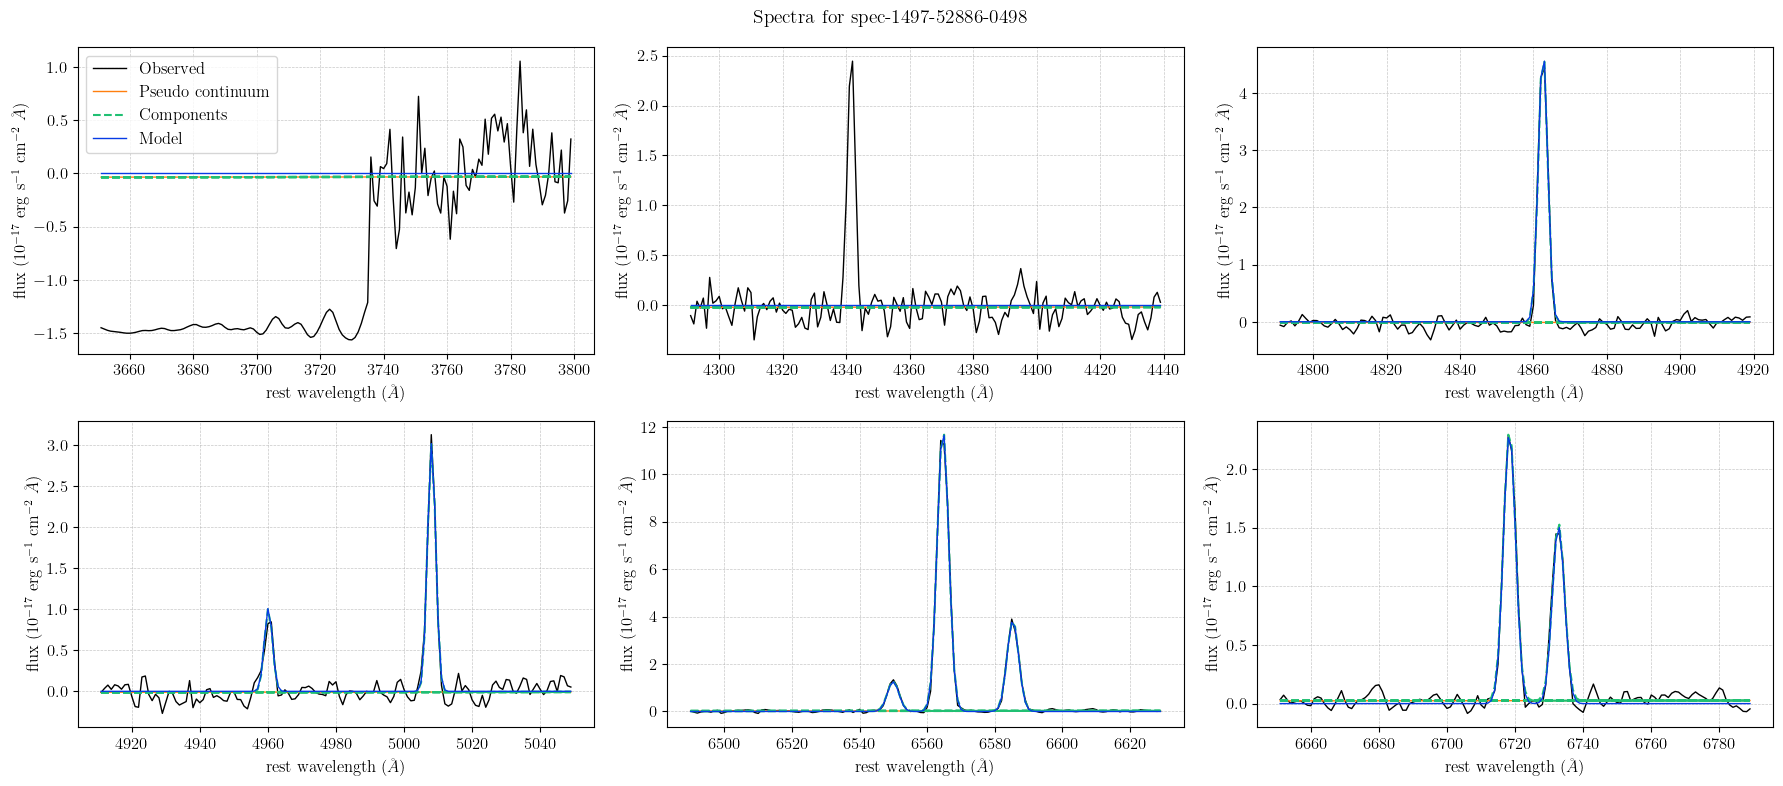

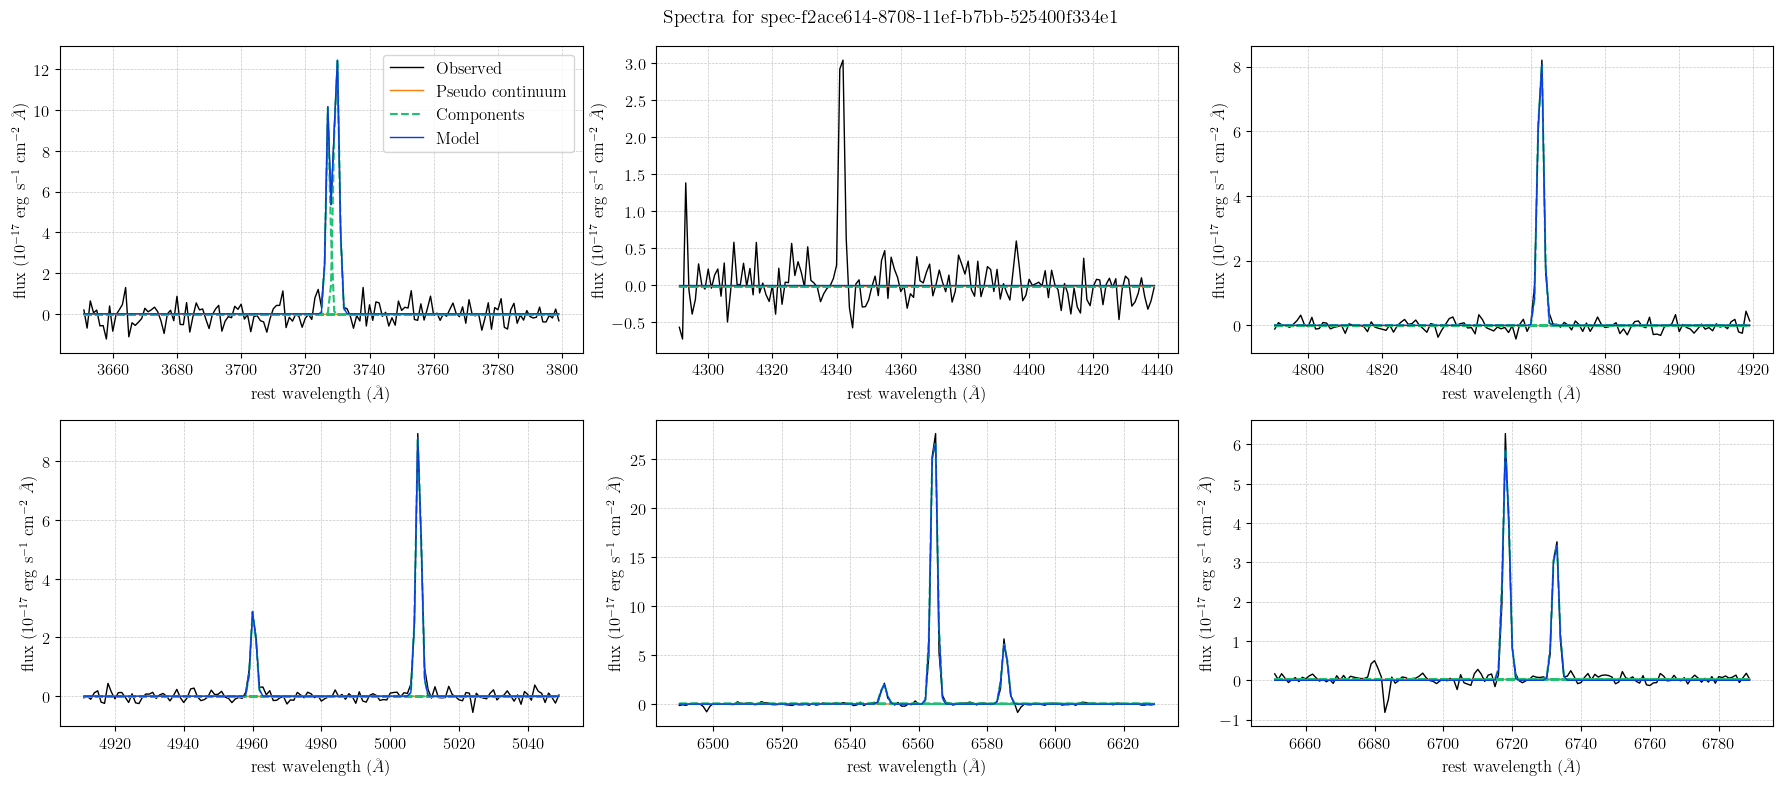

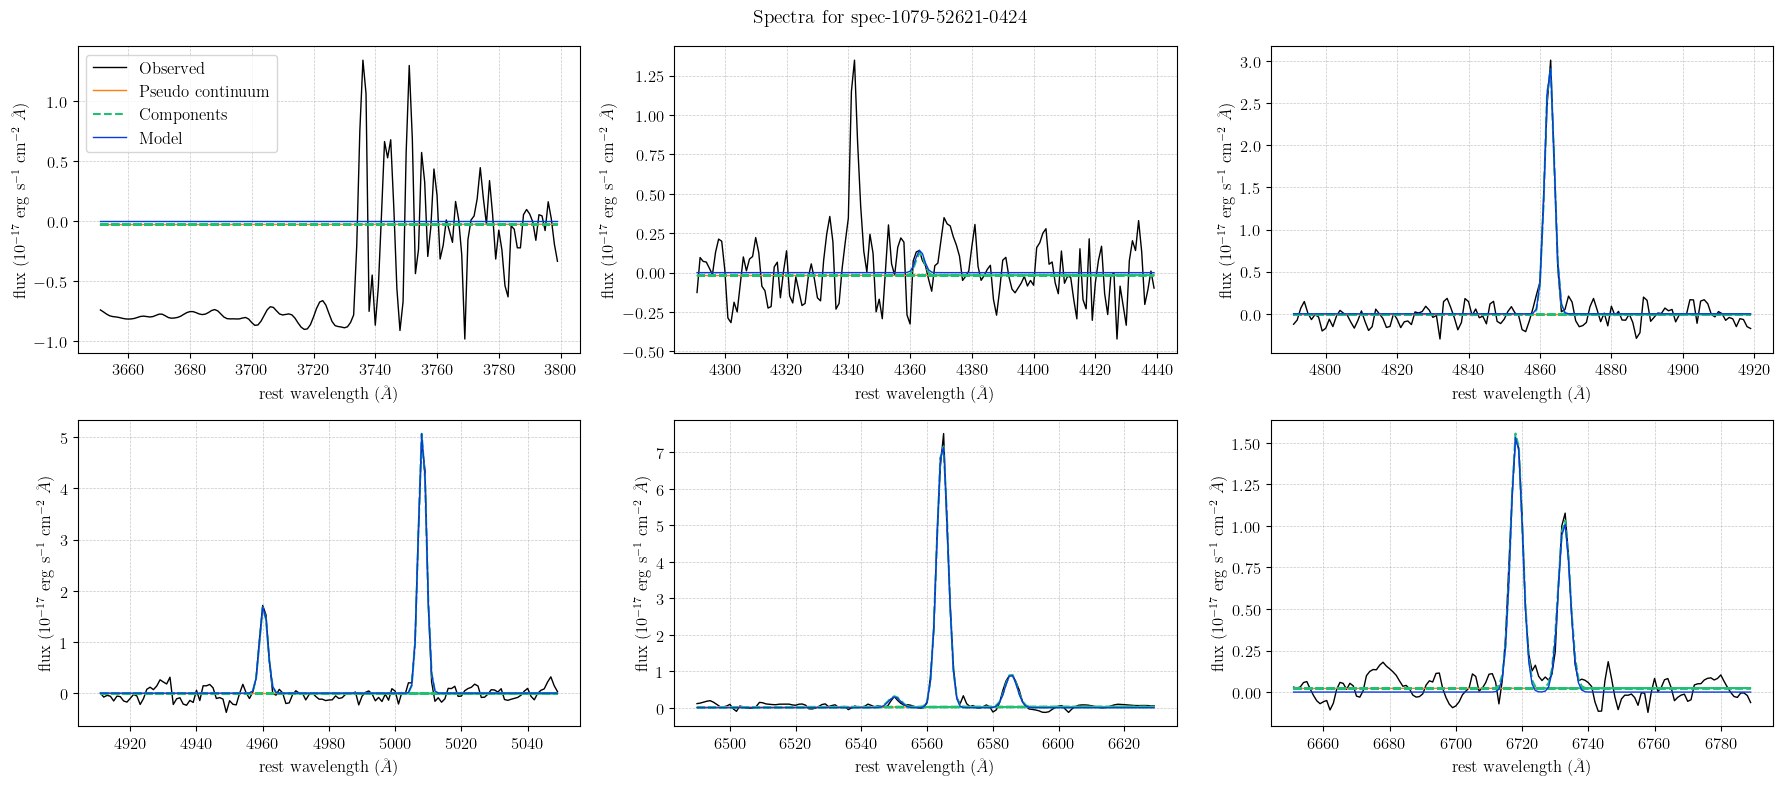

In [9]:
ifscube_fitted_galaxies = [f for f in os.listdir(data_dir) if f.endswith('_g.fits')]
for galaxy in ifscube_fitted_galaxies:
    fig = specutils.plot_ifscube_spectra(data_dir, galaxy)
    # plt.close(fig)